# Forex Trading: MACD Strategy Enhancement with Machine Learning

This notebook demonstrates a complete hybrid workflow:
1. **Genetic Algorithm (GA)**: Optimizes MACD parameters (`Fast`, `Slow`, `Signal`) to find a profitable base strategy.
2. **Machine Learning (Random Forest)**: Filters signals based on a snapshot of indicators at the entry point.
3. **Deep Learning (LSTM)**: Filters signals by analyzing the *sequence* of price action leading up to the entry point.
4. **Performance Analysis**: Calculates detailed metrics like Sharpe Ratio and Max Drawdown.
5. **Comparative Backtest**: Compares the Equity Curve of the Base Strategy vs. ML-Enhanced Strategies.

---

## 1. Setup & Load Data

Loading data for EURUSD=X...


/Users/troytoy/.gemini/antigravity/scratch/ga_ml_trading/data_loader.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Data loaded: 3906 rows


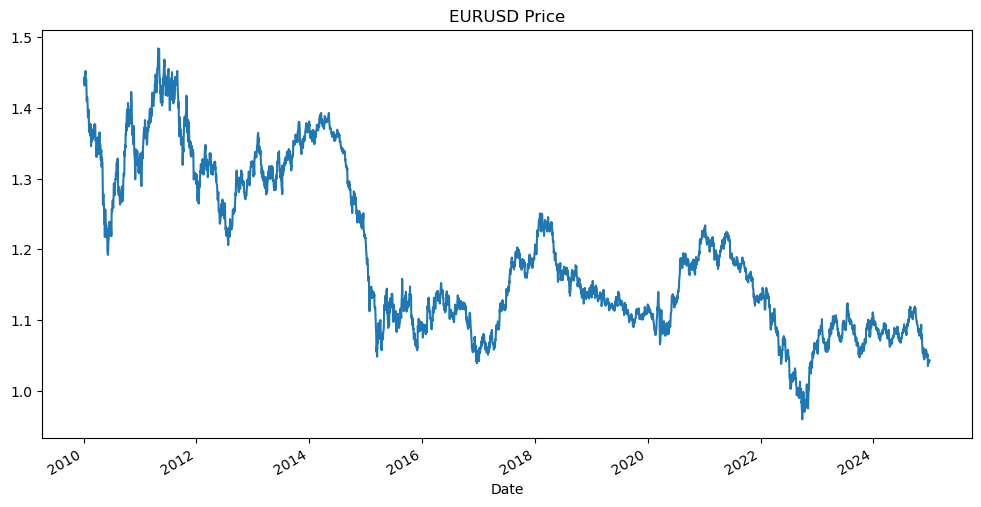

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import random
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
import IPython

# Set Seeds for Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Reload custom modules if edited (Magic commands in pure Python)
try:
    IPython.get_ipython().run_line_magic('load_ext', 'autoreload')
    IPython.get_ipython().run_line_magic('autoreload', '2')
except:
    pass # Handle case where not running in IPython kernel

from data_loader import load_data
from strategy import MACDStrategy
from backtest_metrics import calculate_metrics, print_metrics

# Load Data
df = load_data('EURUSD=X', '2010-01-01', '2024-12-31')
df['Close'].plot(figsize=(12,6), title='EURUSD Price')
plt.show()

## 2. Genetic Algorithm Optimization
We use **DEAP** (Distributed Evolutionary Algorithms in Python) to evolve the MACD parameters.
- **Objective**: Maximize Total Return.
- **Parameters**: Fast Period, Slow Period, Signal Period.
- **Constraint**: Fast < Slow.

In [2]:
# Initialize Strategy Class
strategy = MACDStrategy(df)

# --- GA Setup ---
if hasattr(creator, "FitnessMax"):
    del creator.FitnessMax
if hasattr(creator, "Individual"):
    del creator.Individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_fast", random.randint, 5, 50)
toolbox.register("attr_slow", random.randint, 20, 100)
toolbox.register("attr_signal", random.randint, 5, 50)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_fast, toolbox.attr_slow, toolbox.attr_signal), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    fast, slow, sig = individual
    if fast >= slow: return -9999,
    return strategy.evaluate(fast, slow, sig),

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[5, 20, 5], up=[50, 100, 50], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA
print("Running GA Optimization...")
pop = toolbox.population(n=50)
result_pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=False)

best_ind = tools.selBest(result_pop, 1)[0]
print(f"Best Params Found: Fast={best_ind[0]}, Slow={best_ind[1]}, Signal={best_ind[2]}")
print(f"Best Return: {best_ind.fitness.values[0]:.4f}")

BEST_FAST = best_ind[0]
BEST_SLOW = best_ind[1]
BEST_SIGNAL = best_ind[2]

Running GA Optimization...
Best Params Found: Fast=18, Slow=92, Signal=46
Best Return: 0.2743


## 3. Generate Signals & Features
With the optimized parameters, we generate the trade signals and compute technical indicators to be used as features for ML models.

In [3]:
# Generate Signals with Best Params
df_signals = strategy.generate_signals(BEST_FAST, BEST_SLOW, BEST_SIGNAL)

# Add Technical Features for ML
temp_df = df_signals.copy()
temp_df['rsi'] = ta.momentum.rsi(temp_df['Close'], window=14)
temp_df['atr'] = ta.volatility.average_true_range(temp_df['High'], temp_df['Low'], temp_df['Close'])
temp_df['adx'] = ta.trend.adx(temp_df['High'], temp_df['Low'], temp_df['Close'])

# MACD Specific Features
temp_df['macd_norm'] = temp_df['MACD_Line'] / temp_df['Close']
temp_df['signal_norm'] = temp_df['Signal_Line'] / temp_df['Close']
temp_df['macd_slope'] = temp_df['MACD_Line'].diff()

temp_df.dropna(inplace=True)

# Identify Trade Entry Points (Signal Change)
temp_df['Prev_Signal'] = temp_df['Signal'].shift(1)
trades_df = temp_df[temp_df['Signal'] != temp_df['Prev_Signal']].copy()

# Label Logic: Check if the trade resulted in profit
def get_trade_result(idx, signal, full_df):
    entry_price = full_df.loc[idx, 'Close']
    future_df = full_df.loc[idx:]
    if len(future_df) < 2: return 0
    
    # Find Exit
    future_signals = future_df[future_df['Signal'] != signal]
    if len(future_signals) == 0: return 0
    
    exit_price = future_signals.iloc[0]['Close']
    
    if signal == 1: return (exit_price - entry_price) / entry_price
    else: return (entry_price - exit_price) / entry_price

labels = []
returns = []
for idx, row in trades_df.iterrows():
    ret = get_trade_result(idx, row['Signal'], temp_df)
    returns.append(ret)
    labels.append(1 if ret > 0 else 0)

trades_df['Return'] = returns
trades_df['Label'] = labels

print(f"Total Trades: {len(trades_df)}")
print(f"Profitable: {sum(labels)} ({(sum(labels)/len(labels))*100:.2f}%)")

# Show Base Strategy Metrics
print("\nBased Strategy Performance (Before ML Filtering):")
base_metrics = calculate_metrics(df_signals['Strategy_Returns'], trades_df)
print_metrics(base_metrics)

Total Trades: 90
Profitable: 34 (37.78%)

Based Strategy Performance (Before ML Filtering):

   STRATEGY PERFORMANCE
Total Return        : 27.43%
Annualized Return   : 1.63%
Annualized Volatility: 8.40%
Sharpe Ratio        : 0.19
Max Drawdown        : -25.25%
Win Rate            : 37.78%
Profit Factor       : 1.28
Total Trades        : 90



## 4. Machine Learning Filter (Random Forest)
**Concept**: Use a Random Forest Classifier to analyzing the state of indicators *at the moment of entry*.
- **Input**: RSI, ATR, ADX, MACD Values (Scalar values).
- **Output**: Probability of Profit (0 or 1).

Random Forest Results:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70        18
           1       0.20      0.11      0.14         9

    accuracy                           0.56        27
   macro avg       0.42      0.44      0.42        27
weighted avg       0.49      0.56      0.51        27



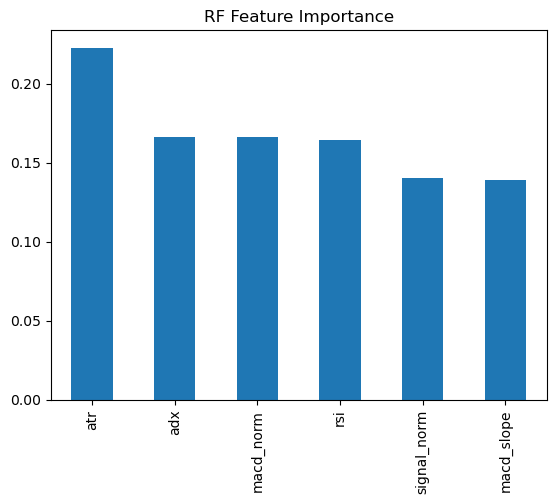

In [4]:
features = ['rsi', 'atr', 'adx', 'macd_norm', 'signal_norm', 'macd_slope']
X = trades_df[features]
y = trades_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, preds))

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind='bar', title='RF Feature Importance')
plt.show()

## 5. Deep Learning Filter (LSTM)
**Concept**: LSTM (Long Short-Term Memory) networks are designed for time-series.
Instead of looking at a single snapshot, we look at the **sequence of data** leading up to the trade.
- **Input**: A sequence of the last 10 candles (RSI, Prices, etc.).
- **Output**: Probability of Profit.

LSTM Data Shape: (89, 10, 6)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


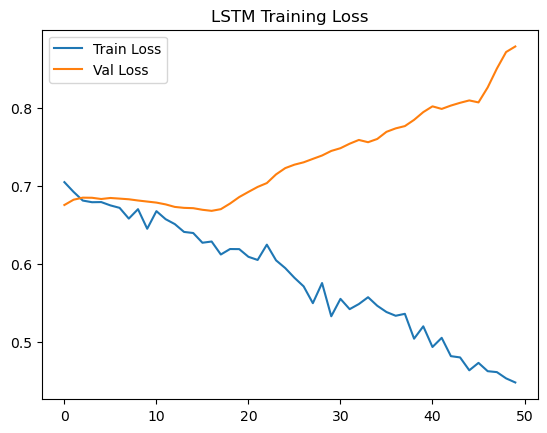

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
LSTM Results:
              precision    recall  f1-score   support

           0       0.46      0.33      0.39        18
           1       0.14      0.22      0.17         9

    accuracy                           0.30        27
   macro avg       0.30      0.28      0.28        27
weighted avg       0.36      0.30      0.32        27



In [5]:
# 1. Prepare Sequences
SEQ_LEN = 10
scaler = StandardScaler()

# Scale the features inside the main dataframe first
df_scaled = temp_df.copy()
df_scaled[features] = scaler.fit_transform(temp_df[features])

# Map datetime index to integer index for easier slicing
feature_data = df_scaled[features].values
idx_map = {idx: i for i, idx in enumerate(df_scaled.index)}

X_lstm = []
y_lstm = []
indices_lstm = [] # Keep track of which trade this is

# Iterate over the identified trades in trades_df
for time_idx in trades_df.index:
    if time_idx not in idx_map: continue
    
    i = idx_map[time_idx]
    if i < SEQ_LEN: continue
    
    # Take sequence [i-SEQ_LEN : i]
    seq = feature_data[i-SEQ_LEN+1 : i+1]
    label = trades_df.loc[time_idx, 'Label']
    
    if len(seq) == SEQ_LEN:
        X_lstm.append(seq)
        y_lstm.append(label)
        indices_lstm.append(time_idx)

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)

print(f"LSTM Data Shape: {X_lstm.shape}")

# 2. Split Data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, idx_train_lstm, idx_test_lstm = train_test_split(
    X_lstm, y_lstm, indices_lstm, test_size=0.3, shuffle=False
)

# 3. Build Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=(SEQ_LEN, len(features)), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=8, validation_split=0.2, verbose=0)

# Plot Training History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

# 5. Evaluate
preds_prob_lstm = model.predict(X_test_lstm)
preds_class_lstm = (preds_prob_lstm > 0.5).astype(int)

print("LSTM Results:")
print(classification_report(y_test_lstm, preds_class_lstm, zero_division=0))

## 6. Comparative Backtest (The Main Result)
Now we apply the ML filters to the test data set to see if they improve the strategy performance.

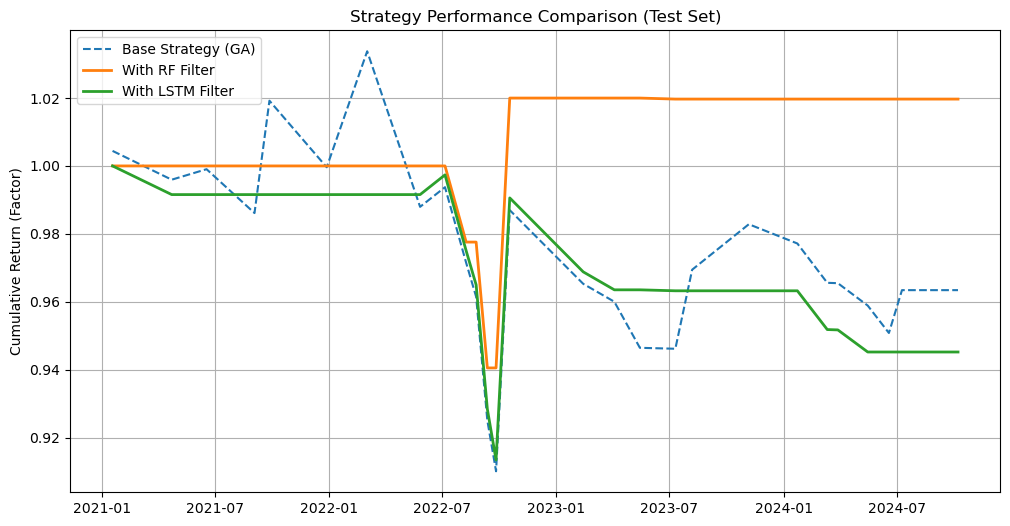

---- Comparative Performance (Test Set Only) ----
1. Base Strategy (GA Only):

   STRATEGY PERFORMANCE
Total Return        : -3.66%
Annualized Return   : -29.36%
Annualized Volatility: 39.74%
Sharpe Ratio        : -0.74
Max Drawdown        : -11.96%
Win Rate            : 33.33%
Profit Factor       : 0.88
Total Trades        : 27

2. With Random Forest Filter:

   STRATEGY PERFORMANCE
Total Return        : 1.97%
Annualized Return   : 19.94%
Annualized Volatility: 29.61%
Sharpe Ratio        : 0.67
Max Drawdown        : -5.94%
Win Rate            : 20.00%
Profit Factor       : 1.39
Total Trades        : 5

3. With LSTM Filter:

   STRATEGY PERFORMANCE
Total Return        : -5.48%
Annualized Return   : -40.88%
Annualized Volatility: 31.35%
Sharpe Ratio        : -1.30
Max Drawdown        : -8.65%
Win Rate            : 14.29%
Profit Factor       : 0.64
Total Trades        : 14



In [6]:
# Prepare Test Set for Comparison (Using the Test Split from RF)
# Note: RandomForest's test set corresponds to the last 30% of trades

test_trades = trades_df.loc[y_test.index].copy()

# 1. Base Strategy (No Filter)
# We already have the 'Return' column
test_trades['Base_Cumulative'] = (1 + test_trades['Return']).cumprod()

# 2. RF Filtered Strategy
test_trades['RF_Pred'] = preds # Predictions from RF
test_trades['RF_Return'] = test_trades.apply(lambda row: row['Return'] if row['RF_Pred'] == 1 else 0, axis=1)
test_trades['RF_Cumulative'] = (1 + test_trades['RF_Return']).cumprod()

# 3. LSTM Filtered Strategy
# Important: LSTM might have slightly fewer samples due to Sequence Drop, need to align
lstm_preds_map = {idx: pred[0] for idx, pred in zip(idx_test_lstm, preds_class_lstm)}
test_trades['LSTM_Pred'] = test_trades.index.map(lstm_preds_map).fillna(0) # Default to 0 if not in LSTM set
test_trades['LSTM_Return'] = test_trades.apply(lambda row: row['Return'] if row['LSTM_Pred'] == 1 else 0, axis=1)
test_trades['LSTM_Cumulative'] = (1 + test_trades['LSTM_Return']).cumprod()

# --- Plot Equity Curves ---
plt.figure(figsize=(12, 6))
plt.plot(test_trades.index, test_trades['Base_Cumulative'], label='Base Strategy (GA)', linestyle='--')
plt.plot(test_trades.index, test_trades['RF_Cumulative'], label='With RF Filter', linewidth=2)
plt.plot(test_trades.index, test_trades['LSTM_Cumulative'], label='With LSTM Filter', linewidth=2)
plt.title('Strategy Performance Comparison (Test Set)')
plt.legend()
plt.ylabel('Cumulative Return (Factor)')
plt.grid(True)
plt.show()

# --- Print Detailed Metrics ---
print("---- Comparative Performance (Test Set Only) ----")
print("1. Base Strategy (GA Only):")
print_metrics(calculate_metrics(test_trades['Return'], test_trades))

print("2. With Random Forest Filter:")
rf_only_trades = test_trades[test_trades['RF_Pred'] == 1]
print_metrics(calculate_metrics(test_trades['RF_Return'], rf_only_trades))

print("3. With LSTM Filter:")
lstm_only_trades = test_trades[test_trades['LSTM_Pred'] == 1]
print_metrics(calculate_metrics(test_trades['LSTM_Return'], lstm_only_trades))

## 7. Visualizing ML Decisions
Let's look at a recent segment of the data to see where ML decided to TAKE (Green) or SKIP (Gray) a trade.

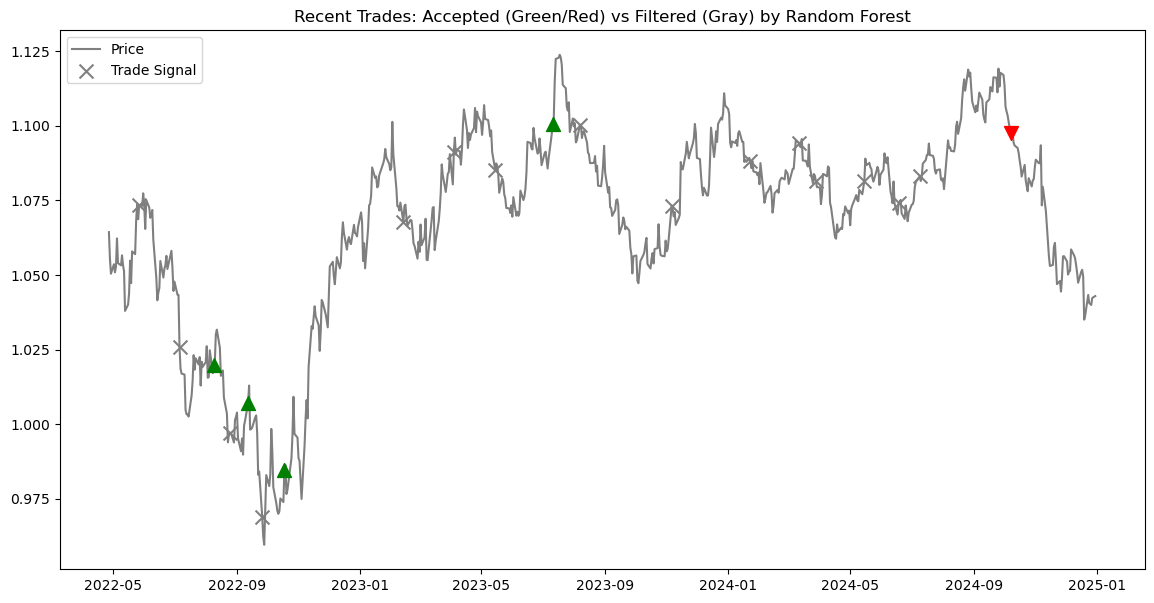

In [7]:
# Filter for recent trades (getLast 20 trades from test set)
recent_trades = test_trades.tail(20)
start_date = recent_trades.index[0] - pd.Timedelta(days=30)
price_data = df.loc[start_date:]

plt.figure(figsize=(14, 7))
plt.plot(price_data.index, price_data['Close'], label='EURUSD Price', alpha=0.5, color='black')

for idx, row in recent_trades.iterrows():
    color = 'grey' # Default: Filtered Out
    marker = 'x'
    label_prefix = "SKIP"
    
    # Check if RF accepted it
    if row['RF_Pred'] == 1:
        if row['Signal'] == 1: # Buy Signal
            color = 'green'
            marker = '^'
            label_prefix = "BUY"
        else: # Sell Signal
            color = 'red'
            marker = 'v'
            label_prefix = "SELL"
    
    plt.scatter(idx, row['Close'], color=color, marker=marker, s=100, zorder=5)

plt.title('Recent Trades: Accepted (Green/Red) vs Filtered (Gray) by Random Forest')
plt.legend(['Price', 'Trade Signal'])
plt.show()